# Spiking network simulation in tensorflow
This is a proof of concept that spikijng nets can be simulated in tensorflow. Code based on the matlab example from
http://www.mjrlab.org/wp-content/uploads/2014/05/CSHA_matlab_2012.pdf and converted by [Joshua Arnold](www.joshuaarnold.com.au)


## Step 1: Simulate a single neuron with injected current
Simulate the neuron model for 1000ms and plot the resulting
voltage trace. Apply a current step (Iapp = 7pA) between time
200ms and 700ms.

In [9]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

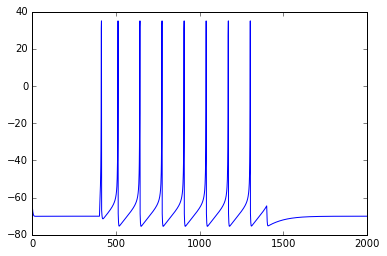

In [10]:
## Model parameters
dt = 0.5
d = 8.0   
a = 0.02
c = -65.0
b = 0.2
T = int(1000 // dt)
v_init = -65
u_init = -14.0

v_shape = [1]
u_shape = v_shape
I_app_shape = v_shape

## Make graph
with tf.Graph().as_default() as tf_graph:
    
    ## Variables in model
    v = tf.Variable(tf.ones(shape=v_shape) * v_init,
                        dtype=tf.float32, name='v')
    u = tf.Variable(tf.ones(shape=v_shape) * u_init,
                        dtype=tf.float32, name='u')
    fired = tf.Variable(np.zeros(v_shape, dtype=bool),
                        dtype=tf.bool, name='fired')
    
    ## Inputs to the model
    I_app = tf.placeholder(tf.float32, shape=I_app_shape)
    
    ## Computation
    # Reset any that spiked last timestep
    v_in = tf.where(fired, tf.ones(tf.shape(v))*c, v)
    u_in = tf.where(fired, tf.ones(tf.shape(u))*tf.add(u, d), u)
    
    # dv = ( 0.04 ∗ v(t) + 5 ) ∗ v(t) + 140 − u(t);
    # v(t+1) = v(t) + (dv + Iapp) ∗ dt;
    dv = tf.subtract(tf.add(tf.multiply(
                tf.add(tf.multiply(0.04, v_in), 5.0), v_in), 140), u_in)
    v_updated = tf.add(v_in, tf.multiply(tf.add(dv, I_app), dt))
    
    # du = a ∗ (b ∗ v(t) − u(t));
    # u(t+1) = u(t) + dt ∗ du;
    du = tf.multiply(a, tf.subtract(tf.multiply(b, v_in), u_in))
    u_out = tf.add(u_in, tf.multiply(dt, du))
    
    # Deal with spikes
    # Limit anything above threshold to threshold value (35)
    # We are saving which fired to use again in the next iteration
    fired_op = fired.assign(tf.greater_equal(v_updated, tf.ones(tf.shape(v)) * 35))
    v_out = tf.where(fired_op, tf.ones(tf.shape(v)) * 35, v_updated)
    
    v_op = v.assign(v_out)
    u_op = u.assign(u_out)
    
## Session 
vs = [np.array(v_init).reshape(1)]
us = [np.array(u_init).reshape(1)]
fires = [np.array(u_init).reshape(1)]
with tf.Session(graph=tf_graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    for t in range(T):
        
        if t * dt > 200 and t * dt < 700:
            iapp = 7.0
        else:
            iapp = 0.0
            
        feed = {I_app: np.array(iapp).reshape(1)}
        
        vo, uo, fire = sess.run([v_op, u_op, fired_op], feed_dict=feed)
        vs.append(vo)
        us.append(uo)
        fires.append(fire)
        
plt.plot([np.asscalar(x) for x in vs])


## Step 2: Single neuron with synaptic input
Simulate the neuron model for 1000ms and plot the resulting
voltage trace. Assume that 100 synapses are attached to the
neuron, with each pre-synaptic neuron firing with a Poisson
process of rate frate = 2 Hz between time 200ms and 700ms.

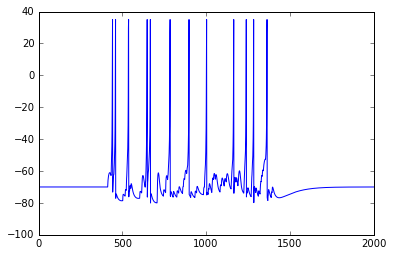

In [11]:
dt = 0.5
d = 8.0   
a = 0.02
c = -65.0
b = 0.2
T = int(1000 // dt)
v_init = -70.0
u_init = -14.0

## NEW
n_in = 100
rate = 2*1e-3 #to ms??
tau_g = 10.0
g_in = np.zeros([n_in, 1])
E_in = np.zeros([n_in, 1])
w_in = 0.07 * np.ones([1, n_in])


with tf.Graph().as_default() as g:
    p04 = tf.constant(0.04)
    five = tf.constant(5.0)
    one_fort = tf.constant(140.0)


    v_in = tf.placeholder(tf.float32, shape=[1])
    u_prev = tf.placeholder(tf.float32, shape=[1])
    I_app = tf.placeholder(tf.float32, shape=[1])
    
    # Reset any above threshold (35)
    cond = tf.greater_equal(v_in, tf.ones(tf.shape(v_in)) * 35)
    v_prev = tf.where(cond, tf.ones(tf.shape(v_in))*c, v_in)


    # dv = ( 0.04 ∗ v(t) + 5 ) ∗ v(t) + 140 − u(t);
    # v(t+1) = v(t) + (dv + Iapp) ∗ dt;
    dv = tf.subtract(tf.add(tf.multiply(tf.add(tf.multiply(p04, v_prev), 5.0), 
                                        v_prev), one_fort), u_prev)
    v = tf.add(v_prev, tf.multiply(tf.add(dv, I_app), dt))

    # du = a ∗ (b ∗ v(t) − u(t));
    # u(t+1) = u(t) + dt ∗ du;
    du = tf.multiply(a, tf.subtract(tf.multiply(b, v_prev), u_prev))
    u = tf.add(u_prev, tf.multiply(dt, du))

    ## if spike
    threshold = tf.constant(35)
    cond = tf.greater_equal(v, tf.ones(tf.shape(v)) * 35)
    v_out = tf.where(cond, tf.ones(tf.shape(v)) * 35, v)
    u_out = tf.where(cond, tf.ones(tf.shape(u))*tf.add(u_prev, d), u)




vs = [np.array(v_init).reshape(1)]
us = [np.array(u_init).reshape(1)]
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    
    for t in range(T):    ## Timesteps
        
        if t * dt > 200 and t*dt < 700:
            p = np.random.rand(n_in, 1) < rate*dt
        else:
            p = np.zeros([n_in,1]) # TODO does this need to be a matrix?
            
        # Set up which fire
        g_in = g_in + p
        iapp = np.matmul(w_in, np.multiply(g_in, E_in))
        iapp = iapp - np.multiply(np.matmul(w_in, g_in), vs[-1])
        g_in = (1 - dt / tau_g) * g_in
            
        feed = {v_in: vs[-1], 
                u_prev: us[-1],
                I_app: np.array(iapp).reshape(1)}
        
        vo, uo = sess.run([v_out, u_out], feed_dict=feed)
        vs.append(vo)
        us.append(uo)
        
plt.plot([np.asscalar(x) for x in vs])
    


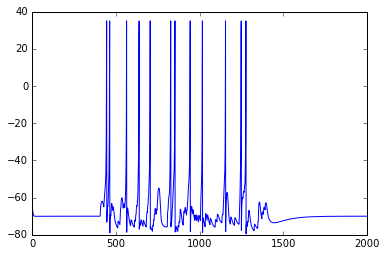

In [12]:
### NEAT VERSION OF THE ABOVE
## Model parameters
dt = 0.5
d = 8.0   
a = 0.02
c = -65.0
b = 0.2
T = int(1000 // dt)
v_init = -65
u_init = -14.0
n_in = 100
rate = 2*1e-3
tau_g = 10.0

v_shape = [1]
u_shape = v_shape
I_app_shape = v_shape
E_shape = [n_in, 1]         # <- NEW
w_in_shape = [1, n_in]      # <- NEW
p_shape = [n_in, 1]
g_in_shape = [n_in, 1]

## Make graph
with tf.Graph().as_default() as tf_graph:
    
    # Constants
    E_in = tf.constant(0.0, shape=E_shape)       # <- NEW
    w_in = tf.constant(0.07, shape=w_in_shape)    # <- NEW
    
    ## Variables in model
    v = tf.Variable(tf.ones(shape=v_shape) * v_init,
                        dtype=tf.float32, name='v')
    u = tf.Variable(tf.ones(shape=v_shape) * u_init,
                        dtype=tf.float32, name='u')
    g_in = tf.Variable(tf.zeros(shape=g_in_shape),     # <- NEW
                        dtype=tf.float32, name='g_in')
    fired = tf.Variable(np.zeros(v_shape, dtype=bool),
                        dtype=tf.bool, name='fired')
    
    
    ## Inputs to the model
    p_in = tf.placeholder(tf.float32, shape=p_shape)   # <- NEW
    
    ## Computation
    # Conductance update of g_in
    g_inp = g_in + p_in                                # <- NEW
    iapp = tf.reshape(tf.matmul(w_in, np.multiply(g_inp, E_in)) - \
                    tf.multiply(tf.matmul(w_in, g_in), v), 
                    tf.shape(v))                      # <- NEW
    g_in_op = g_in.assign((1 - dt / tau_g) * g_inp)   # <- NEW
    
    # Reset any that spiked last timestep
    v_in = tf.where(fired, tf.ones(tf.shape(v))*c, v)
    u_in = tf.where(fired, tf.ones(tf.shape(u))*tf.add(u, d), u)
    
    # dv = ( 0.04 ∗ v(t) + 5 ) ∗ v(t) + 140 − u(t);
    # v(t+1) = v(t) + (dv + Iapp) ∗ dt;
    dv = tf.subtract(tf.add(tf.multiply(
                tf.add(tf.multiply(0.04, v_in), 5.0), v_in), 140), u_in)
    v_updated = tf.add(v_in, tf.multiply(tf.add(dv, iapp), dt))
    
    # du = a ∗ (b ∗ v(t) − u(t));
    # u(t+1) = u(t) + dt ∗ du;
    du = tf.multiply(a, tf.subtract(tf.multiply(b, v_in), u_in))
    u_out = tf.add(u_in, tf.multiply(dt, du))
    
    # Deal with spikes
    # Limit anything above threshold to threshold value (35)
    # We are saving which fired to use again in the next iteration
    fired_op = fired.assign(tf.greater_equal(v_updated, tf.ones(tf.shape(v)) * 35))
    v_out = tf.where(fired_op, tf.ones(tf.shape(v)) * 35, v_updated)
    
    v_op = v.assign(v_out)
    u_op = u.assign(u_out)
    
## Session 
vs = [np.array(v_init).reshape(1)]
us = [np.array(u_init).reshape(1)]
fires = [np.array(u_init).reshape(1)]
with tf.Session(graph=tf_graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    for t in range(T):
        
        if t * dt > 200 and t*dt < 700:                
            p = np.random.rand(n_in, 1) < rate*dt     # <- NEW
        else:                                         
            p = np.zeros([n_in,1])                    # <- NEW
            
        feed = {p_in: p}                              # <- NEW
        
        vo, uo, _, fire = sess.run(
                    [v_op, u_op, g_in_op, fired_op], # <- NEW
                    feed_dict=feed)
        vs.append(vo)
        us.append(uo)
        fires.append(fire)
        
plt.plot([np.asscalar(x) for x in vs])




## Step 3: Simulate 1000 neurons (not inter-connected)
Simulate 1000 neurons for 1000 ms and plot the resulting spikes.
Assume that each neuron receives (random) 10% of the 100
Poisson spike trains of rate frate = 2 Hz between time 200 ms and
700 ms. Note that the neurons are not yet inter-connected (so the fact some are inhibitory doesn't affect the systems dynamics).

Because there are no lateral/recurrent connections the inhibitory vs the excitatory make very little difference.

float64


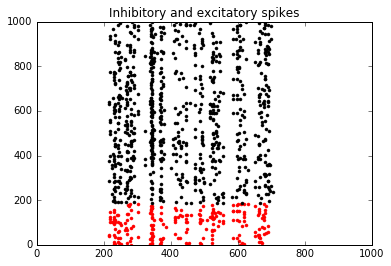

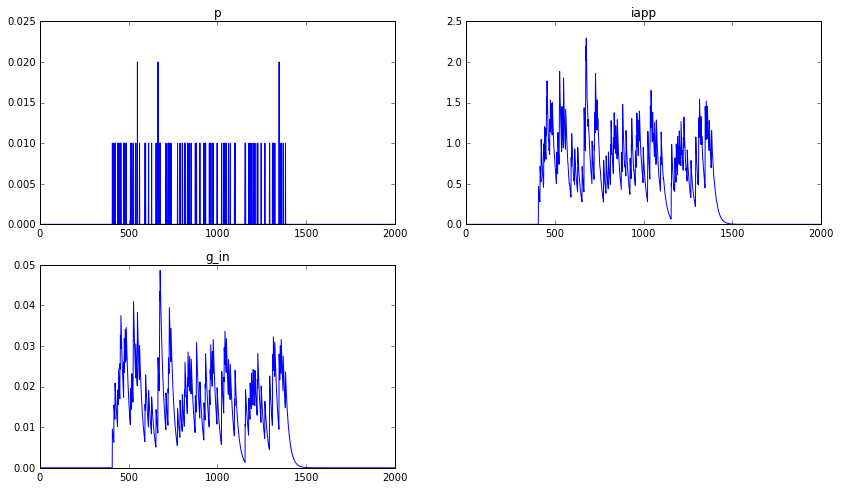

In [13]:
dt = 0.5
n = 1000
inh = np.random.rand(n, 1) < 0.2 # Percent inhibitory
exc = np.logical_not(inh)
d = 8.0 * exc + 2.0 * inh
a = 0.02 * exc + 0.1 * inh
c = -65.0
T = int(1000 // dt)
v_init = np.ones([n, 1]) * -70.0 
u_init = np.ones([n, 1]) * -14.0 
tp = tf.float32

## NEW
n_in = 100
rate = 2*1e-3
tau_g = 10.0
g_in = np.zeros([n_in, 1])
E_in = np.zeros([n_in, 1])
w_in = 0.07 * np.ones([n, n_in])
w_in[np.random.rand(n, n_in) > 0.1] = 0  # input conection prob


with tf.Graph().as_default() as g:
    p04 = tf.constant(0.04, dtype=tp)
    five = tf.constant(5.0, dtype=tp)
    one_fort = tf.constant(140.0, dtype=tp)
    b = tf.constant(0.2, dtype=tp)
    dt_g = tf.constant(dt, dtype=tp)
    a_g = tf.constant(dt, dtype=tp)


    v_in = tf.placeholder(tp, shape=[n, 1])
    u_prev = tf.placeholder(tp, shape=[n, 1])
    I_app = tf.placeholder(tp, shape=[n, 1])
    
    # Reset any above threshold (35)
    cond = tf.greater_equal(v_in, tf.ones(tf.shape(v_in)) * 35)
    v_prev = tf.where(cond, tf.ones(tf.shape(v_in))*c, v_in)


    # dv = ( 0.04 ∗ v(t) + 5 ) ∗ v(t) + 140 − u(t);
    # v(t+1) = v(t) + (dv + Iapp) ∗ dt;
    dv = tf.subtract(tf.add(tf.multiply(tf.add(tf.multiply(p04, v_prev), five), 
                                        v_prev), one_fort), u_prev)
    v1 = tf.add(dv, I_app)
    v2 = tf.multiply(v1, dt_g)
    v = tf.add(v_prev, v2)

    # du = a ∗ (b ∗ v(t) − u(t));
    # u(t+1) = u(t) + dt ∗ du;
    du1 = tf.multiply(b, v_prev)
    du2 = tf.subtract(du1, u_prev)
    du = tf.multiply(a_g, du2)
    u = tf.add(u_prev, tf.multiply(dt_g, du))
    

    ## if spike
    threshold = tf.constant(35, dtype=tp)
    cond = tf.greater_equal(v, tf.ones(tf.shape(v)) * 35)
    v_out = tf.where(cond, tf.ones(tf.shape(v)) * 35, v)
    u_out = tf.where(cond, tf.ones(tf.shape(u))*tf.add(u_prev, d), u)



vs = [v_init]  # now v_init is shape=(n,1)
us = [u_init]
var_names = ['p', 'iapp', 'g_in']
stats = {name:[] for name in var_names }
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    
    for t in range(T):    ## Timesteps
        
        if t * dt > 200 and t*dt < 700:
            p = np.random.rand(n_in, 1) < rate*dt
        else:
            p = np.zeros([n_in,1])
            
        # Set up which fire
        g_in = g_in + p
        iapp = np.matmul(w_in, np.multiply(g_in, E_in))
        iapp = iapp - np.multiply(np.matmul(w_in, g_in), vs[-1])
        g_in = (1 - dt / tau_g) * g_in
        
        # this is a bit of a hack to collect statistics to graph for debugging
        for name in var_names:
            exec("stats['{0}'].append({0}.mean())".format(name))
            
        feed = {v_in: vs[-1], 
                u_prev: us[-1],
                I_app: np.array(iapp).reshape([n, 1])}
        
        vo, uo = sess.run([v_out, u_out], feed_dict=feed)
        vs.append(vo)
        us.append(uo)
        
#plt.plot([np.asscalar(x) for x in vs])
allv = np.array(vs).reshape(2001, 1000)
spks = allv == 35
plt.figure()
inha, inhb = np.nonzero(spks[:,inh.reshape(1000)])
plt.plot(inha*dt, inhb, 'r.')
exca, excb = np.nonzero(spks[:,exc.reshape(1000)])
plt.plot(exca*dt, excb + inhb.max(), 'k.')
plt.axis([0, T*dt, 0, n])
plt.title('Inhibitory and excitatory spikes')

rows = int(np.ceil(len(var_names)/2))
plt.figure(figsize=(14,rows*4))
for i, name in enumerate(var_names):
    plt.subplot(int("{}{}{}".format( rows, 2, i+1)))
    plt.plot(stats[name])
    plt.title(name)

## Step 3.1: Rewrite Step 3
After getting a model working in step 3 I tried to rewrite it more completely in just the tensorflow graph but spent far to long trying to debug and so I leave my attempt here as a record and as inspiration.

4.19790104948e-05


'rows = int(np.ceil(len(var_names)/2))\nplt.figure(figsize=(14,rows*4))\nfor i, name in enumerate(var_names):\n    plt.subplot(int("{}{}{}".format( rows, 2, i+1)))\n    plt.plot(stats[name])\n    plt.title(name)'

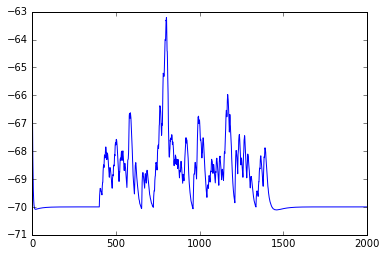

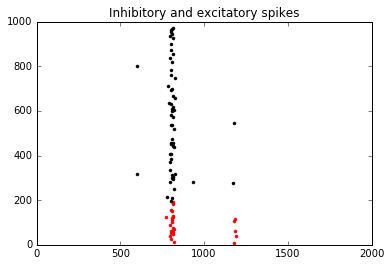

In [6]:
## Model parameters
dt = 0.5
d = 8.0   
#a = 0.02
c = -65.0
b = 0.2
T = int(1000 // dt)
v_init = -65
u_init = -14.0
n_in = 100
rate = 2*1e-3
tau_g = 10.0
n = 1000            # NEW

v_shape = [n, 1]            # NEW
u_shape = v_shape
I_app_shape = v_shape
E_shape = [n_in, 1]  
w_in_shape = [n, n_in]      # NEW
p_shape = [n_in, 1]
g_in_shape = [n_in, 1]

## Make graph
with tf.Graph().as_default() as tf_graph:
    
    # Constants
    E_in = tf.constant(0.0, shape=E_shape)       
    #w_in = tf.constant(0.07, shape=w_in_shape)
    # Connection probability
    conections = tf.greater_equal(tf.random_uniform([n, n_in]), 0.1)   # NEW
    w_in = tf.where(conections, tf.constant(0.0, shape=[n, n_in]), tf.constant(0.07, shape=[n, n_in]))
    
    
    inh = tf.less_equal(tf.random_uniform([n, 1]), 0.2)
    exc = tf.logical_not(inh)             # NEW
    inh_num = tf.cast(inh, tf.float32)    # NEW
    exc_num = tf.cast(exc, tf.float32)    # NEW
    d = (8.0 * exc_num) + (2.0 * inh_num)         # NEW
    a = (0.02 * exc_num) + (0.1 * inh_num)    # NEW
    
    ## Variables in model
    v = tf.Variable(tf.ones(shape=v_shape) * v_init,
                        dtype=tf.float32, name='v')
    u = tf.Variable(tf.ones(shape=v_shape) * u_init,
                        dtype=tf.float32, name='u')
    g_in = tf.Variable(tf.zeros(shape=g_in_shape),   
                        dtype=tf.float32, name='g_in')
    fired = tf.Variable(np.zeros(v_shape, dtype=bool),
                        dtype=tf.bool, name='fired')
    
    
    ## Inputs to the model
    p_in = tf.placeholder(tf.float32, shape=p_shape) 
    
    
    
    ## Computation
    # Conductance update of g_in
    g_inp = g_in + p_in
    iapp = tf.reshape(tf.matmul(w_in, np.multiply(g_inp, E_in)) - \
                    tf.multiply(tf.matmul(w_in, g_inp), v), 
                    tf.shape(v))
    
    g_in_op = g_in.assign((1 - dt / tau_g) * g_inp)  
    
    # Reset any that spiked last timestep
    v_in = tf.where(fired, tf.ones(tf.shape(v))*c, v)
    u_in = tf.where(fired, tf.ones(tf.shape(u))*tf.add(u, d), u)
    
    # dv = ( 0.04 ∗ v(t) + 5 ) ∗ v(t) + 140 − u(t);
    # v(t+1) = v(t) + (dv + Iapp) ∗ dt;
    dv = tf.subtract(tf.add(tf.multiply(
                tf.add(tf.multiply(0.04, v_in), 5.0), v_in), 140), u_in)
    v_updated = tf.add(v_in, tf.multiply(tf.add(dv, iapp), dt))
    
    # du = a ∗ (b ∗ v(t) − u(t));
    # u(t+1) = u(t) + dt ∗ du;
    du = tf.multiply(a, tf.subtract(tf.multiply(b, v_in), u_in))
    u_out = tf.add(u_in, tf.multiply(dt, du))
    
    # Deal with spikes
    # Limit anything above threshold to threshold value (35)
    # We are saving which fired to use again in the next iteration
    fired_op = fired.assign(tf.greater_equal(v_updated, tf.ones(tf.shape(v)) * 35))
    v_out = tf.where(fired_op, tf.ones(tf.shape(v)) * 35, v_updated)
    
    p_in_mean = tf.reduce_mean(v_out)
    v_op = v.assign(v_out)
    u_op = u.assign(u_out)
    
## Session 
vs = [np.ones([n, 1]) * v_init]
us = [np.ones([n, 1]) * u_init]
fires = [np.array(u_init).reshape(1)]
means = []
with tf.Session(graph=tf_graph) as sess:
    sess.run(tf.global_variables_initializer())
    
    for t in range(T):
        
        if t * dt > 200 and t*dt < 700:                
            p = np.random.rand(n_in, 1) < rate*dt 
        else:                                         
            p = np.zeros([n_in,1])  
            
        feed = {p_in: p}       
        
        vo, uo, _, fire, meanv = sess.run(
                    [v_op, u_op, g_in_op, fired_op, p_in_mean], 
                    feed_dict=feed)
        vs.append(vo)
        us.append(uo)
        fires.append(fire)
        means.append(meanv)
    
    ## Grab which neurons are which for plotting
    inh_logical, exc_logical = sess.run([inh, exc])
    
plt.plot(means)

        
#plt.plot([np.asscalar(x) for x in vs])
allv = np.array(vs).reshape(T + 1, n)
spks = allv == 35
#print(spks.mean())
plt.figure()
inha, inhb = np.nonzero(spks[:,inh_logical.reshape(n)])
plt.plot(inha, inhb, 'r.')
exca, excb = np.nonzero(spks[:,exc_logical.reshape(n)])
plt.plot(exca, excb + inhb.max(), 'k.')
plt.axis([0, T, 0, n])
plt.title('Inhibitory and excitatory spikes')

"""rows = int(np.ceil(len(var_names)/2))
plt.figure(figsize=(14,rows*4))
for i, name in enumerate(var_names):
    plt.subplot(int("{}{}{}".format( rows, 2, i+1)))
    plt.plot(stats[name])
    plt.title(name)"""



## Step 4: Simulate recurrent network
Simulate 1000 neurons as before but with added recurrent connections.

A neuron i is sparsely (with probability
prc = 0.1) connected to a neuron j.
Thus neuron i receives an additional
current I. See slides for equation

Weights are Gamma distributed (scale
0.003, shape 2). Inh. to exc.
connections are twice as strong.

Step for had some initial attempts at refactoring into just the Tensorflow graph but after the step 3 rewrite halted this one too stopped whilst still in a working condition. 

W: 0.00039452465573 w_in: 0.0069573


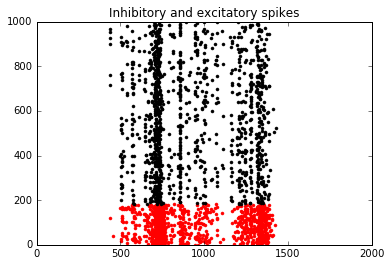

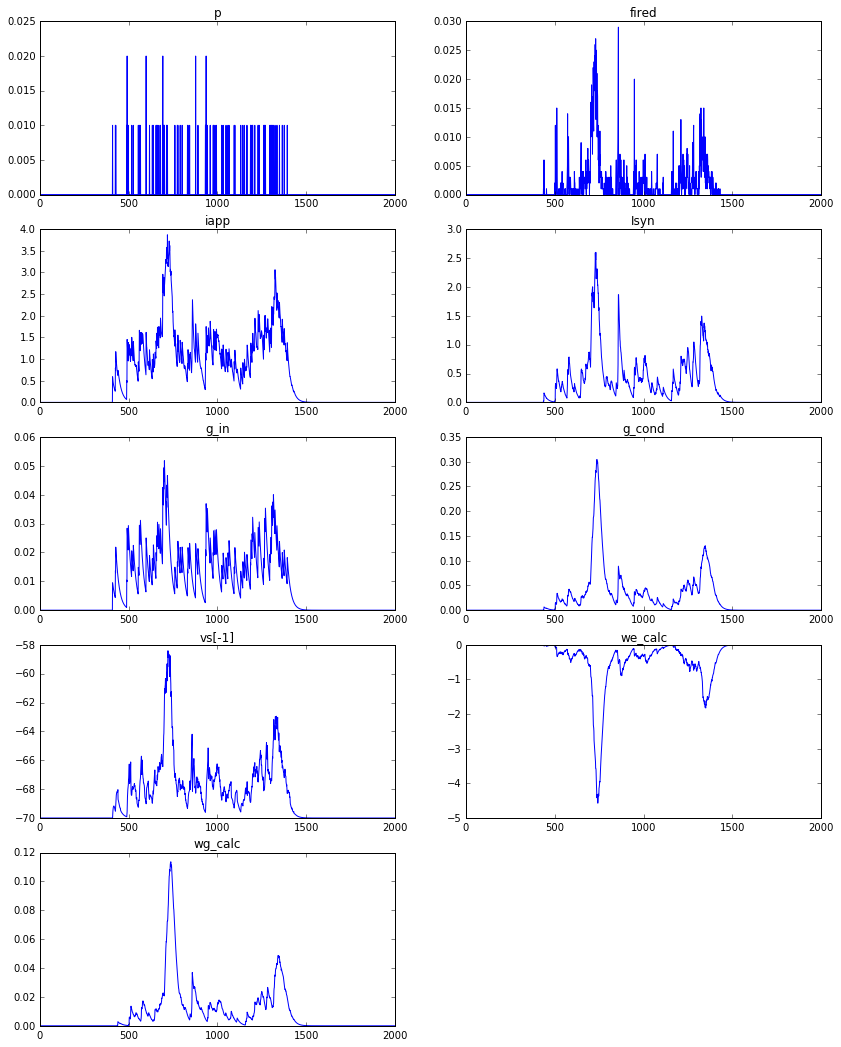

In [32]:
dt = 0.5
n = 1000
inh = np.random.rand(n, 1) < 0.2  # Percent inhibitory
exc = np.logical_not(inh)
d = 8.0 * exc + 2.0 * inh
a = 0.02 * exc + 0.1 * inh
c = -65.0
T = int(1000 // dt)
v_init = np.ones([n, 1]) * -70.0 
u_init = np.ones([n, 1]) * -14.0 
tp = tf.float32

n_in = 100
rate = 2*1e-3 
tau_g = 10.0
g_in = np.zeros([n_in, 1])
E_in = np.zeros([n_in, 1])
w_in = 0.07 * np.ones([n, n_in])
w_in[np.random.rand(n, n_in)>0.1] = 0  # input conection prob

# New to step 4
g_cond = np.zeros([n, 1])
E = np.zeros([n, 1])
E[inh] = -85.0
idx = np.random.rand(n, n) < 0.05  # Percent recurrent connections
W = idx * np.random.gamma(2, 0.003, size=[n, n])
inh2exc = np.matmul(inh, np.transpose(exc))
W += (W * inh2exc * 2)

with tf.Graph().as_default() as g:
    p04 = tf.constant(0.04, dtype=tp)
    five = tf.constant(5.0, dtype=tp)
    one_fort = tf.constant(140.0, dtype=tp)
    b = tf.constant(0.2, dtype=tp)
    dt_g = tf.constant(dt, dtype=tp)
    a_g = tf.constant(dt, dtype=tp)


    v_in = tf.placeholder(tp, shape=[n, 1])
    u_prev = tf.placeholder(tp, shape=[n, 1])
    I_app = tf.placeholder(tp, shape=[n, 1])  
    
    # Reset any above threshold (35)
    units_fired = tf.greater_equal(v_in, tf.ones(tf.shape(v_in)) * 35)
    v_prev = tf.where(units_fired, tf.ones(tf.shape(v_in))*c, v_in)


    # dv = ( 0.04 ∗ v(t) + 5 ) ∗ v(t) + 140 − u(t);
    # v(t+1) = v(t) + (dv + Iapp) ∗ dt;
    dv = tf.subtract(tf.add(tf.multiply(tf.add(tf.multiply(p04, v_prev), five), 
                                        v_prev), one_fort), u_prev)
    v1 = tf.add(dv, I_app)
    v2 = tf.multiply(v1, dt_g)
    v = tf.add(v_prev, v2)

    # du = a ∗ (b ∗ v(t) − u(t));
    # u(t+1) = u(t) + dt ∗ du;
    du1 = tf.multiply(b, v_prev)
    du2 = tf.subtract(du1, u_prev)
    du = tf.multiply(a_g, du2)
    u = tf.add(u_prev, tf.multiply(dt_g, du))
    

    ## if spike
    threshold = tf.constant(35, dtype=tp)
    cond = tf.greater_equal(v, tf.ones(tf.shape(v)) * 35)
    v_out = tf.where(cond, tf.ones(tf.shape(v)) * 35, v)
    u_out = tf.where(cond, tf.ones(tf.shape(u))*tf.add(u_prev, d), u)



vs = [v_init]  # now v_init is shape=(n,1)
us = [u_init]
fired = np.zeros([n, 1])
var_names = ['p', 'fired', 'iapp', 'Isyn', 'g_in', 'g_cond', 'vs[-1]', 'we_calc', "wg_calc"]
stats = {name:[] for name in var_names }
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    
    for t in range(T):    ## Timesteps
        
        if t * dt > 200 and t*dt < 700:
            p = np.random.rand(n_in, 1) < rate*dt
        else:
            p = np.zeros([n_in,1]) 
            
        # Set up which fire
        g_in = g_in + p
        iapp = np.matmul(w_in, np.multiply(g_in, E_in))
        iapp = iapp - np.multiply(np.matmul(w_in, g_in), vs[-1])
        g_in = (1 - dt / tau_g) * g_in
        
        
        g_cond = g_cond + fired
        """isyn = np.matmul(W, np.multiply(g_cond, E)) - np.multiply(np.matmul(W, g_cond), vs[-1])
        iapp = iapp + isyn
        g_cond = (1 - dt / tau_g) * g_cond"""
        # Isyn = W ∗ (g.∗E) − (W∗g) .∗ v(:,t);
        e_calc = np.multiply(g_cond, E)
        we_calc = np.matmul(W, e_calc)
        wg_calc = np.matmul(W, g_cond)   
        Isyn = we_calc - np.multiply(wg_calc, vs[-1])
        iapp += Isyn
        g_cond = (1 - dt / tau_g) * g_cond
        
        for name in var_names:
            exec("stats['{0}'].append({0}.mean())".format(name))
        
        feed = {v_in: vs[-1], 
                u_prev: us[-1],
                I_app: np.array(iapp).reshape([n, 1])}
        
        vo, uo, fired = sess.run([v_out, u_out, cond], feed_dict=feed)
        vs.append(vo)
        us.append(uo)
        
#plt.plot([np.asscalar(x) for x in vs])
allv = np.array(vs).reshape(2001, 1000)
spks = allv == 35
#plt.figure()
#plt.plot(wgs)

plt.figure()
inha, inhb = np.nonzero(spks[:,inh.reshape(1000)])
plt.plot(inha, inhb, 'r.')
exca, excb = np.nonzero(spks[:,exc.reshape(1000)])
plt.plot(exca, excb + inhb.max(), 'k.')
plt.axis([0, T, 0, n])
plt.title('Inhibitory and excitatory spikes')

plt.figure(figsize=(14,18))
for i, name in enumerate(var_names):
    #print("{}{}{}".format( round(len(var_names)/2), 2, i))
    plt.subplot(int("{}{}{}".format( int(np.ceil(len(var_names)/2)), 2, i+1)))
    plt.plot(stats[name])
    plt.title(name)
print("W:", W.mean(), "w_in:", w_in.mean())

Now we have seen each example of a spiking net in matlab converted to the tensorflow framework. Quick thoughts?
- Felt clunkier than using matlab. Things like plotting, printing and indexing often felt awkward*
- Felt like I was always stuck on implementation issues* such as how to use particular functions or how to structure to get logic in the computation graph. 
- Logic in the compuation graph felt unnatural, things like spiking only during the 200-700ms timeframe didn't lend well to being inside the computation graph. 
- Development time took a lot longer and required significantly more debugging than expected
- Speed increase over matlab? untested.

*This might just be because of familiarity with Matlab vs Tensorflow